# Photovoltaics Interactive Tabletop Supporting Code

`Cristian Sorescu 879091`


Human activity recognition in indoor environments is useful for comfortable and efficient living and working in smart homes and buildings. Energy harvesting technologies such as the photovoltaics could offer advantages for low-cost installation and maintenance, portability and energy savings. We explore large area indoor photovoltaic (PV) sheets for both energy harvesting and gesture recognition.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, itertools, pywt, scipy
from collections import Counter
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# CNN
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Flatten, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# KNN
from sklearn.neighbors import KNeighborsClassifier


Using TensorFlow backend.


## Helper Functions

In [1367]:
# Lag Features generation, 
# predict the value at the next time (t+1) given the value at the previous time (t-1).
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

# definition of cnn model
def get_model(_shape, num_classes):
    # number of classes
    #nclass = 6
    
    inp = Input(shape=_shape)
    print(inp)
    
    # layers
    # kernel size as tuple
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(num_classes, activation=activations.softmax, name="dense_3")(dense_1)

    # model definition
    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy) # metrics=['accuracy']
    model.summary()
    
    return model

# extract filename from a given path
def path_to_fname(_path):
    return os.path.basename(os.path.splitext(_path)[0])

# remove digits and underscore _ from a given string
def rm_digit_undscore(_string):
    return ''.join(c for c in _string if not c.isdigit() and not c == '_')

# Confusion matrix plot function definition
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()

# load data from given file list    
def load_data(file_list):
    classes = []
    gestures = []
    
    for fp in file_list:
        gesture = pd.read_csv(fp, delim_whitespace=False, header=[0, 1], index_col=0)
        gesture = gesture.rolling(window = 100).mean()
        gesture = gesture.dropna()
        gestures.append(gesture.values.squeeze())
        classes.append(rm_digit_undscore(path_to_fname(fp)))
    
    gestures = np.array(gestures)
    classes = np.array(classes)
    return classes, gestures

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def lowpassfilter(data, thresh = 0.63, waveletname = "db4"):
    thresh = thresh*np.nanmax(data)
    coeff = pywt.wavedec(data, waveletname, mode="per")
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname, mode="per")
    
    return reconstructed_signal

# apply low-pass filter on given data 
def apply_lowpassfilter(dataset, waveletname = "db4"):
    data_lowpassfilter = []
    dataset = dataset.reshape(dataset.shape[0], dataset.shape[2])

    batch_size = dataset.shape[0]
    for i in range(batch_size):
        data_lowpassfilter.append(lowpassfilter(dataset[i, :], 0.4, waveletname))
    
    data_lowpassfilter = np.array(data_lowpassfilter)
    data_lowpassfilter = np.expand_dims(data_lowpassfilter, axis=[1,-1])
    return data_lowpassfilter

'''
    Below are features which are most frequently used for time series signals.

    Auto-regressive model coefficient values
    (Shannon) Entropy values; entropy values can be taken as a measure of complexity of the signal.
    Statistical features like:
        variance
        standard deviation
        Mean
        Median
        25th percentile value
        75th percentile value
        Root Mean Square value; 
        square of the average of the squared amplitude values
        The mean of the derivative
        Zero crossing rate, i.e. the number of times a signal crosses y = 0
        Mean crossing rate, i.e. the number of times a signal crosses y = mean(y)
'''

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1] / len(list_values) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)
    return entropy

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

# extract features for each file (gesture) in the dataset
def get_gestures_features(dataset, labels, waveletname):
    all_features = []
    dataset = dataset.reshape(dataset.shape[0], dataset.shape[2])
    for i in range(len(dataset)):
        features = []
        data_i = dataset[i, :]
        list_coeff = pywt.wavedec(data_i, waveletname)
        for coeff in list_coeff:
            features += get_features(coeff)
        all_features.append(features)
    
    data = np.array(all_features)
    data = np.expand_dims(data, axis=[1,-1])
    classes = np.array(labels)
    
    return data, classes

## Load Gestures Data and Classes

In [1368]:
path = "csv/data/*/"
gestures_files = glob.glob(path + '/*.csv')
classes, data = load_data(gestures_files)

data = np.expand_dims(data, axis=1)
print(data.shape)

(154, 1, 14905)


## Split Gestures Data Into Train/Test Sets

In [1369]:
train_data, test_data,\
train_classes, test_classes = train_test_split(data, classes, test_size=0.25, random_state=42)

print("Train samples: {0}, Test samples: {1}".format(train_data.shape[0], test_data.shape[0]))

Train samples: 115, Test samples: 39


## CNN

input layer parameters (batchSize, length, channels).

batchSize = number of gesture files (optional)    
length = number of lines in each file   
?? channels = dimension of the embedding's output (calsses)  

## Encode Class Labels

In [1170]:
# encode labels
label_encoder = preprocessing.LabelEncoder()
enc_labels = label_encoder.fit_transform(classes)

print("*Encoded labels*\n")
for (enc, name) in zip(np.unique(enc_labels), np.unique(classes)):
    print("Gesture class: {0}, Label: {1}".format(name, enc))

*Encoded labels*

Gesture class: clockwise, Label: 0
Gesture class: counterclockwise, Label: 1
Gesture class: fistForm, Label: 2
Gesture class: raiseLower, Label: 3
Gesture class: swipe, Label: 4
Gesture class: swipes, Label: 5


In [1169]:
num_classes = len(np.unique(classes))
cnn_model = get_model(train_data[0, 0, :].shape, num_classes)

Tensor("input_1:0", shape=(None, 14905, 1), dtype=float32)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14905, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14901, 16)         96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14897, 16)         1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7448, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7448, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7446, 32)          1568      
_________________________________________________________________


In [895]:
# early = EarlyStopping(monitor="accuracy", mode="max", patience=5, verbose=1)
# redonplat = ReduceLROnPlateau(monitor="accuracy", mode="max", patience=3, verbose=2)
# callbacks_list = [early, redonplat]

# fit data into the cnn model, training
cnn_model.fit(train_data[:,0,:], enc_labels, epochs=400, verbose=1)

Epoch 1/400
116/116 [==============================] - 11s 94ms/step - loss: 1.7849
Epoch 2/400
116/116 [==============================] - 10s 88ms/step - loss: 1.7855
Epoch 3/400
116/116 [==============================] - 11s 93ms/step - loss: 1.7828
Epoch 4/400
116/116 [==============================] - 10s 89ms/step - loss: 1.7800
Epoch 5/400
116/116 [==============================] - 10s 88ms/step - loss: 1.7800
Epoch 6/400
116/116 [==============================] - 10s 87ms/step - loss: 1.7788
Epoch 7/400
116/116 [==============================] - 10s 87ms/step - loss: 1.7687
Epoch 8/400
116/116 [==============================] - 13s 110ms/step - loss: 1.7623
Epoch 9/400
116/116 [==============================] - 11s 94ms/step - loss: 1.7527
Epoch 10/400
116/116 [==============================] - 10s 87ms/step - loss: 1.7311
Epoch 11/400
116/116 [==============================] - 10s 87ms/step - loss: 1.7158
Epoch 12/400
116/116 [==============================] - 10s 87ms/step - l

Epoch 98/400
116/116 [==============================] - 10s 87ms/step - loss: 0.4732
Epoch 99/400
116/116 [==============================] - 10s 87ms/step - loss: 0.5139
Epoch 100/400
116/116 [==============================] - 11s 91ms/step - loss: 0.4875
Epoch 101/400
116/116 [==============================] - 10s 87ms/step - loss: 0.4612
Epoch 102/400
116/116 [==============================] - 10s 86ms/step - loss: 0.5287
Epoch 103/400
116/116 [==============================] - 10s 87ms/step - loss: 0.5014
Epoch 104/400
116/116 [==============================] - 10s 86ms/step - loss: 0.5059
Epoch 105/400
116/116 [==============================] - 10s 87ms/step - loss: 0.4830
Epoch 106/400
116/116 [==============================] - 10s 87ms/step - loss: 0.5394
Epoch 107/400
116/116 [==============================] - 10s 87ms/step - loss: 0.5744
Epoch 108/400
116/116 [==============================] - 10s 87ms/step - loss: 0.5345
Epoch 109/400
116/116 [==============================] -

Epoch 194/400
116/116 [==============================] - 10s 88ms/step - loss: 0.4742
Epoch 195/400
116/116 [==============================] - 10s 89ms/step - loss: 0.4423
Epoch 196/400
116/116 [==============================] - 10s 89ms/step - loss: 0.4517
Epoch 197/400
116/116 [==============================] - 10s 87ms/step - loss: 0.3967
Epoch 198/400
116/116 [==============================] - 11s 92ms/step - loss: 0.4306
Epoch 199/400
116/116 [==============================] - 11s 95ms/step - loss: 0.4435
Epoch 200/400
116/116 [==============================] - 11s 95ms/step - loss: 0.4317
Epoch 201/400
116/116 [==============================] - 10s 88ms/step - loss: 0.4201
Epoch 202/400
116/116 [==============================] - 10s 89ms/step - loss: 0.3947
Epoch 203/400
116/116 [==============================] - 11s 95ms/step - loss: 0.3876
Epoch 204/400
116/116 [==============================] - 10s 88ms/step - loss: 0.3997
Epoch 205/400
116/116 [==============================]

Epoch 290/400
116/116 [==============================] - 10s 87ms/step - loss: 0.2919
Epoch 291/400
116/116 [==============================] - 10s 87ms/step - loss: 0.2450
Epoch 292/400
116/116 [==============================] - 10s 88ms/step - loss: 0.2143
Epoch 293/400
116/116 [==============================] - 10s 87ms/step - loss: 0.2572
Epoch 294/400
116/116 [==============================] - 10s 86ms/step - loss: 0.2012
Epoch 295/400
116/116 [==============================] - 10s 87ms/step - loss: 0.2508
Epoch 296/400
116/116 [==============================] - 10s 87ms/step - loss: 0.2443
Epoch 297/400
116/116 [==============================] - 10s 88ms/step - loss: 0.2097
Epoch 298/400
116/116 [==============================] - 10s 86ms/step - loss: 0.2847
Epoch 299/400
116/116 [==============================] - 10s 87ms/step - loss: 0.2567
Epoch 300/400
116/116 [==============================] - 10s 87ms/step - loss: 0.2402
Epoch 301/400
116/116 [==============================]

Epoch 386/400
116/116 [==============================] - 10s 86ms/step - loss: 0.1796
Epoch 387/400
116/116 [==============================] - 10s 86ms/step - loss: 0.2353
Epoch 388/400
116/116 [==============================] - 10s 86ms/step - loss: 0.2044
Epoch 389/400
116/116 [==============================] - 10s 86ms/step - loss: 0.1661
Epoch 390/400
116/116 [==============================] - 10s 86ms/step - loss: 0.2020
Epoch 391/400
116/116 [==============================] - 10s 86ms/step - loss: 0.2339
Epoch 392/400
116/116 [==============================] - 10s 89ms/step - loss: 0.1583
Epoch 393/400
116/116 [==============================] - 10s 87ms/step - loss: 0.1644
Epoch 394/400
116/116 [==============================] - 10s 87ms/step - loss: 0.1929
Epoch 395/400
116/116 [==============================] - 10s 87ms/step - loss: 0.2092
Epoch 396/400
116/116 [==============================] - 10s 86ms/step - loss: 0.1886
Epoch 397/400
116/116 [==============================]

In [978]:
cnn_pred = cnn_model.predict(test_data[:,0,:,:])
cnn_pred = np.argmax(cnn_pred, axis=-1)
cnn_pred = label_encoder.inverse_transform(cnn_pred)

correct_preds = np.nonzero(cnn_pred == test_classes)[0]
incorrect_preds = np.nonzero(cnn_pred != test_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

cnn_train_score = rf_model.score(train_data[:,0,:], test_classes)
print("Accuracy on the train dataset: ", cnn_train_score)

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_classes, cnn_pred, average="macro")
print("\nTest f1 score : %s "% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_classes, cnn_pred)
print("Test accuracy score : %s"% acc)


Test f1 score : 0.9280748663101605 
Test accuracy score : 0.9318181818181818


### CNN Confusion matrix

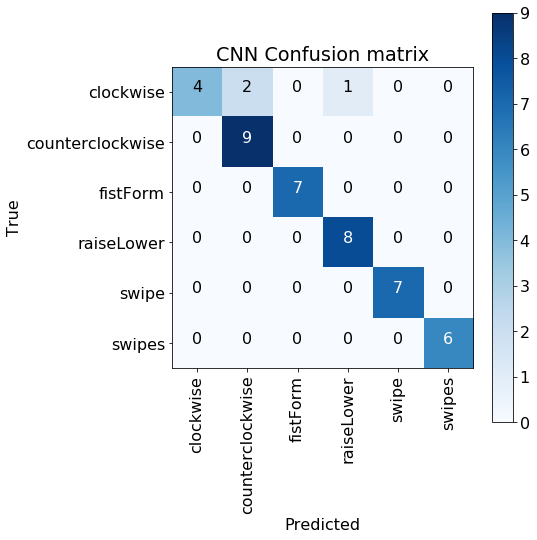

In [900]:
# compute confusion matrix
cnn_matrix = confusion_matrix(test_classes, cnn_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnn_matrix, np.unique(test_classes), title='CNN Confusion matrix')

## Extract Features
Extract features from the getures datasets (train and test)

In [1370]:
# train features
train_features, train_ft_classes = get_gestures_features(train_data, train_classes, 'db1')
print('Extracted train features shape: {0}'.format(train_features.shape))

Extracted train features shape: (115, 1, 168, 1)


In [1371]:
# test features
test_features, test_ft_classes = get_gestures_features(test_data, test_classes, 'db1')
print('Extracted test features shape: {0}'.format(test_features.shape))

Extracted test features shape: (39, 1, 168, 1)


## KNN
Classifier implementing the k-nearest neighbors vote.

In [1372]:
knn_model = KNeighborsClassifier(n_neighbors=6)

In [1373]:
knn_model.fit(train_features[:,0,:,0], train_ft_classes)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [1374]:
# apply knn model on test data
knn_pred = knn_model.predict(test_features[:,0,:,0])

correct_preds = np.nonzero(knn_pred == test_ft_classes)[0]
incorrect_preds = np.nonzero(knn_pred != test_ft_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

# compute accuracy of the knn model
knn_train_score = knn_model.score(train_features[:,0,:,0], train_ft_classes)
print("Accuracy on the train dataset: ", knn_train_score)

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_ft_classes, knn_pred, average="macro")
print("Test f1 score : %s "% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_ft_classes, knn_pred)
print("Accuracy on the test dataset: %s"% acc)


35 classified correctly
4 classified incorrectly
Accuracy on the train dataset:  0.8434782608695652
Test f1 score : 0.9028083028083028 
Accuracy on the test dataset: 0.8974358974358975


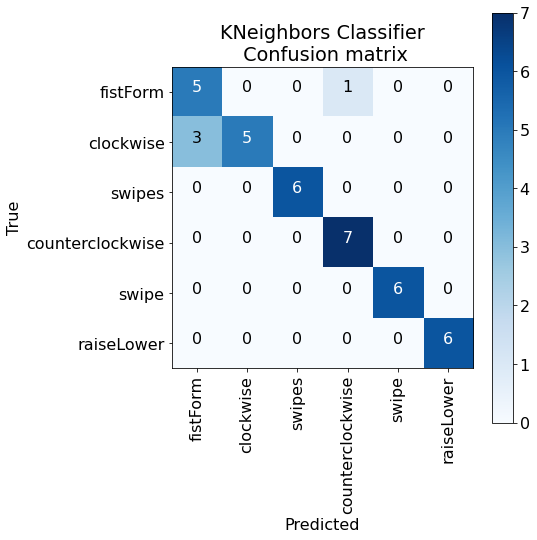

In [1375]:
# compute confusion matrix
knn_matrix = confusion_matrix(test_classes, knn_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(knn_matrix, set(test_classes), title='KNeighbors Classifier\n Confusion matrix')

## Random Forest

In [1012]:
# random forest model
parameters = {'bootstrap': True,
              'n_estimators': 200, 
              'min_samples_split': 2,
              'max_depth': 6}

rf_model = RandomForestClassifier(**parameters)

In [1381]:
# fit/train random forest model
rf_model.fit(train_features[:,0,:,0], train_ft_classes)
#print('train data shape: ', train_features.shape)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1382]:
# apply random forest model on test data
#print('test data shape: ', test_features.shape)
rf_pred = rf_model.predict(test_features[:,0,:,0])

correct_preds = np.nonzero(rf_pred == test_ft_classes)[0]
incorrect_preds = np.nonzero(rf_pred != test_ft_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

rf_train_score = rf_model.score(train_features[:,0,:,0], train_ft_classes)
print("Accuracy on the train dataset: ", rf_train_score)

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_ft_classes, rf_pred, average="macro")
print("Test f1 score : %s "% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_ft_classes, rf_pred)
print("Accuracy on the test dataset: %s"% acc)

38 classified correctly
1 classified incorrectly
Accuracy on the train dataset:  1.0
Test f1 score : 0.9750445632798573 
Accuracy on the test dataset: 0.9743589743589743


### Random Forest Confusion matrix

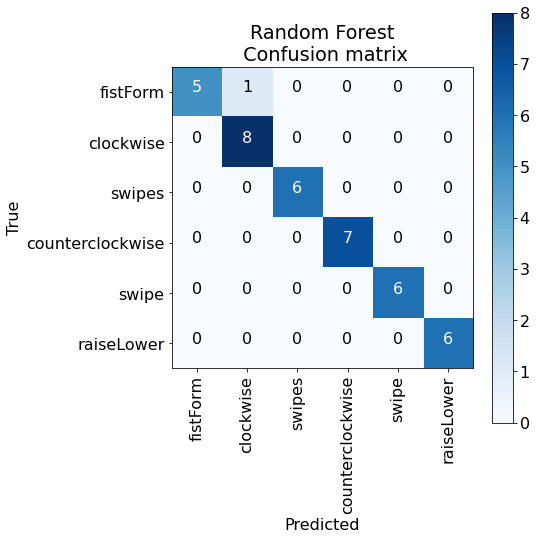

In [1383]:
# compute confusion matrix
rf_matrix = confusion_matrix(test_ft_classes, rf_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(rf_matrix, set(test_ft_classes), title='Random Forest\n Confusion matrix')

## Gradient Boosting Classifier

In [1036]:
# Gradient Boosting Classifier (GBC) model
parameters = {'n_estimators': 100, 'max_depth': 2}
gbc_model = GradientBoostingClassifier(**parameters)

In [1166]:
# fit/train GBC model
gbc_model.fit(train_features[:,0,:,0], train_ft_classes)
#print('train data shape: ', train_features.shape)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [1167]:
# apply GBC model on test data
#print('test data shape: ', test_features.shape)
gbc_pred = gbc_model.predict(test_features[:,0,:,0])

correct_preds = np.nonzero(gbc_pred == test_ft_classes)[0]
incorrect_preds = np.nonzero(gbc_pred != test_ft_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

# compute accuracy of the GBC model
gbc_train_score = gbc_model.score(train_features[:,0,:,0], train_ft_classes)
print("Accuracy on the train dataset: ", gbc_train_score)

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_ft_classes, gbc_pred, average="macro")
print("Test f1 score: %s"% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_ft_classes, gbc_pred)
print("Accuracy on the test dataset: %s"% acc)

36 classified correctly
3 classified incorrectly
Accuracy on the train dataset:  1.0
Test f1 score: 0.9306818181818182
Accuracy on the test dataset: 0.9230769230769231


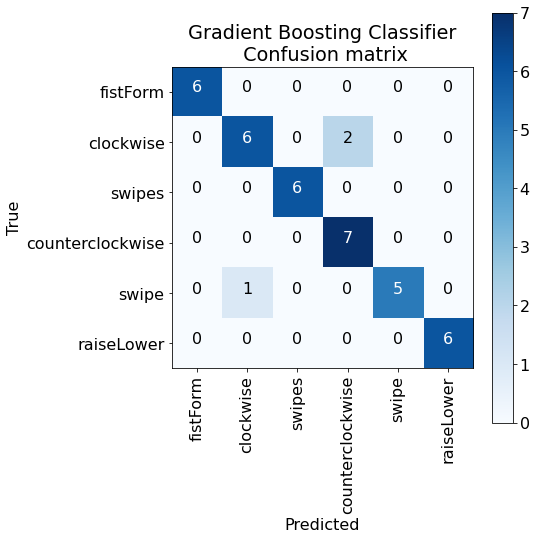

In [1168]:
# compute confusion matrix
gbc_matrix = confusion_matrix(test_ft_classes, gbc_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(gbc_matrix, set(test_ft_classes), title='Gradient Boosting Classifier\n Confusion matrix')

## Plot Sample Gestures Readings

In [1072]:
# read_csv parameters
csv_params = "delim_whitespace=False, header=[0, 1], index_col=0"

# gestures data
gestures = []

# fist formation gesture
handDetect = pd.read_csv('csv/tests/hand_detected_1.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([handDetect, 'Hand Detetction'])
# fist formation gesture
fistForm = pd.read_csv('csv/data/fistForm/fistForm_08.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([fistForm, 'Fist Formation'])
# clockwise motion gesture
clockwise = pd.read_csv('csv/data/clockwise/clockwise_06.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([clockwise, 'Clockwise Motion'])
# counterclockwise motion gesture
counterclockwise = pd.read_csv('csv/data/counterclockwise/counterclockwise_03.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([counterclockwise, 'Counterclockwise Motion'])
# continuous swipes motion gesture
swipe = pd.read_csv('csv/data/swipe/swipe_03.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([swipe, 'Singular Swipe'])
# singular swipe motion gesture
swipes = pd.read_csv('csv/data/swipes/swipes_03.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([swipes, 'Continuous Swipes'])
# raise and Lower hand motion
raiseLower = pd.read_csv('csv/data/raiseLower/raiseLower_01.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([raiseLower, 'Raise/Lower Hand Motion'])

# testing
gesture = fistForm

#gesture = series_to_supervised(gesture, 79)
print(gesture.shape)

(15004, 1)


In [386]:
# # rolling mean of gesture, reduce noise
# rollingMean_train = gesture.rolling(window = 100).mean()
# rollingMean_train = rollingMean_train.dropna().drop_duplicates()

# # define training data for gesture based on the rolling mean
# y_train = np.array(rollingMean_train.values).astype(np.double)[:,0]
# x_train = np.transpose(np.array(rollingMean_train.values))[..., np.newaxis]
# x_train = np.expand_dims(x_train, axis=0)

# # y_train = np.expand_dims(y_train, axis=-1)
# # print(y_train.shape)

# print(y_train.shape)
# print(x_train.shape)

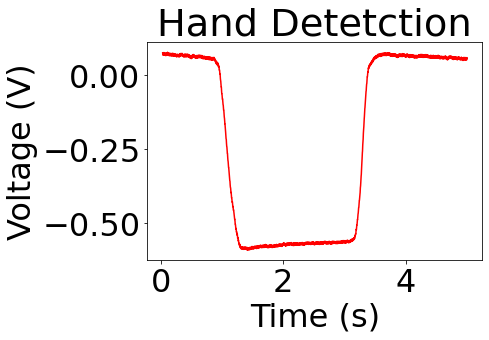

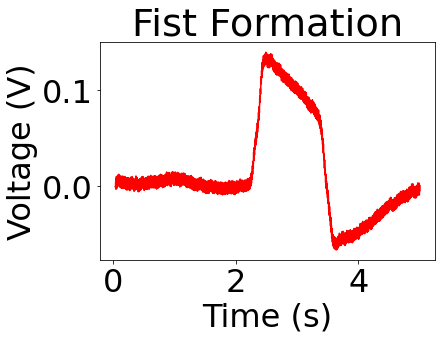

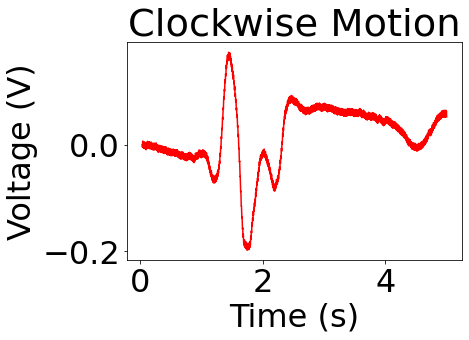

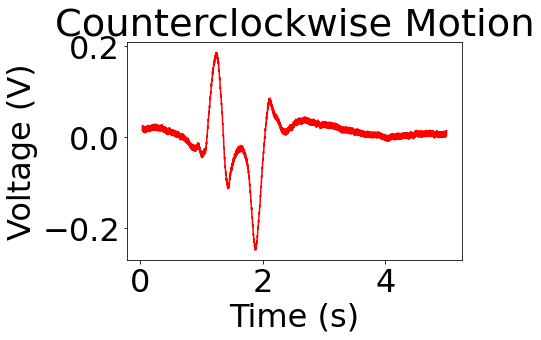

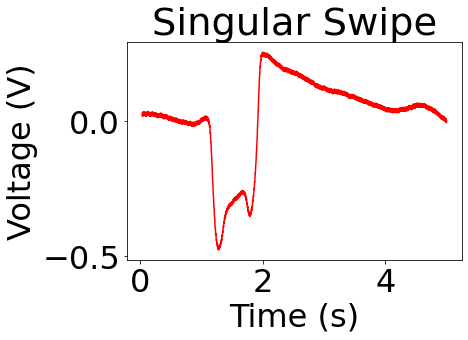

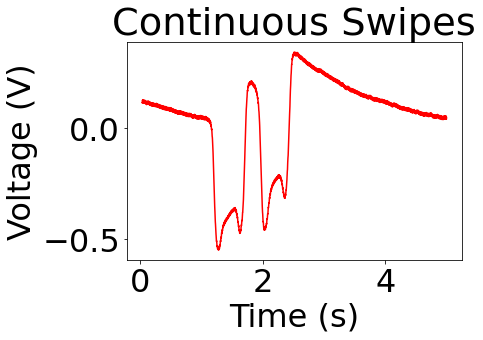

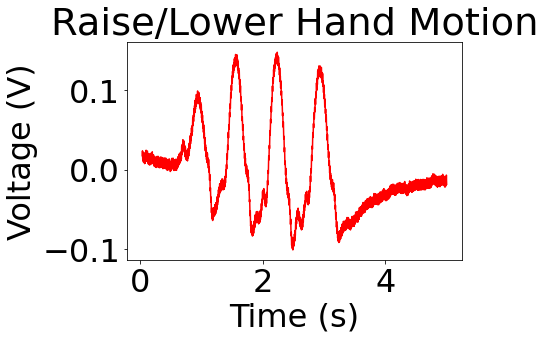

In [1073]:
plt.rcParams.update({'font.size': 32})

for gesture in gestures:
    gestureDF, title = gesture
    #gestureDF.columns = gestureDF.columns.droplevel(1)
    plotTitle = title

    rollingMean = gestureDF.rolling(window = 100).mean()
    rollingMean = rollingMean.dropna().drop_duplicates()
    rollingStd = gestureDF.rolling(window = 12).std()
    #plt.plot(gestureDF, color = 'blue', label = 'Original')
    plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
    #plt.plot(rollingStd, color = 'black', label = 'Rolling STD')
    #plt.legend(loc = 'best', prop={'size': 13})
    plt.title(plotTitle)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    #minR = round(gestureDF.min().to_numpy()[0], 1)
    #maxR = round(gestureDF.max().to_numpy()[0], 1)
    #plt.yticks(np.arange(minR, maxR, step=0.3)) 
    plt.show()

## Other stuff

In [23]:
# tests

# inp =  Input(shape=(5, 1))
# conv = Convolution1D(filters=2, kernel_size=2)(inp)
# pool = MaxPool1D(pool_size=2)(conv)
# flat = Flatten()(pool)
# dense = Dense(1)(flat)
# model = models.Model(inp, dense)
# model.compile(loss='mse', optimizer='adam')

# #print(model.summary())

# # get some data
# X = np.expand_dims(np.random.randn(10, 5), axis=2)
# y = np.random.randn(10, 1)

# print(X.shape)
# print(y.shape)

# # fit model
# model.fit(X, y)

In [ ]:
# plot the data

#fistForm.shape
#fistForm.head(3)
gestures[:5]

#handDetect['Channel A'].plot(linewidth=1);
#fistForm['Channel A'].plot(linewidth=1);
#clockwise['Channel A'].plot(linewidth=1);

# tsfresh Tests

In [ ]:
# extract features
fistForm.reset_index(inplace=True)
fistForm_features = tsfresh.extract_features(fistForm, column_id='index', n_jobs=4)

#fistForm_features = tsfresh.extract_features(fistForm)

#clockwise_features = tsfresh.extract_features(clockwise)

#counterclockwise_features = tsfresh.extract_features(counterclockwise)

#swipes_features = tsfresh.extract_features(swipes)

#swipe_features = tsfresh.extract_features(swipe)

#raiseLower_features = tsfresh.extract_features(raiseLower)

In [ ]:
from tsfresh.utilities.dataframe_functions import impute

impute(handDetect_features)

In [ ]:
#handDetect_features.head()
#handDetect.resample('3T').sum()
#handDetect.describe()

In [19]:
for gesture in gestures:
    gestureDF, title = gesture
    print(round(gestureDF.max().to_numpy()[0], 1))

0.1
-0.1
-1.1
0.1
0.1
-0.9
-0.2


In [ ]:
# tests

# import mass_ts as mts

# ts = handDetect3.to_numpy()
# q = handDetect.to_numpy()

# print(handDetect3[:,0])

# # mass
# distances = mts.mass(ts[:,0], q[:,0])

# # mass2
# distances = mts.mass2(ts[:,0], q[:,0])

# # mass3
# #distances = mts.mass3(ts[:,0], q[:,0], 256)

# # mass2_batch
# # start a multi-threaded batch job with all cpu cores and give me the top 5 matches.
# # note that batch_size partitions your time series into a subsequence similarity search.
# # even for large time series in single threaded mode, this is much more memory efficient than
# # MASS2 on its own.
# batch_size = 10000
# top_matches = 5
# n_jobs = 3
# indices, distances = mts.mass2_batch(ts[:,0], q[:,0], batch_size, 
#     top_matches=top_matches, n_jobs=n_jobs)

# # find minimum distance
# min_idx = np.argmin(distances)

# # find top 4 motif starting indices
# k = 4
# exclusion_zone = 25
# top_motifs = mts.top_k_motifs(distances, k, exclusion_zone)

# # find top 4 discord starting indices
# k = 4
# exclusion_zone = 25
# top_discords = mts.top_k_discords(distances, k, exclusion_zone)

# Wavelet analysis

In [1340]:
import pywt
x = fistForm.values
# Discrete Wavelet Transform
#cA, cD = pywt.dwt(x, 'db2')
#x2 = pywt.idwt(cA, cD, 'db2')
x

Time,Channel A
(s),(V)
0.000000,-0.026856
0.000333,-0.038820
0.000667,-0.040712
0.001000,-0.050661
0.001333,-0.059999
...,...
4.999827,-0.015809
5.000160,-0.018311
5.000494,-0.032777


In [16]:
# for mode_name in ['zero', 'constant', 'symmetric', 'reflect', 'periodic', 'smooth', 'periodization']:
#     mode = getattr(pywt.Modes, mode_name)
#     cA, cD = pywt.dwt(x, 'db2', mode)
#     print("Mode: %d (%s)" % (mode, mode_name))

Mode: 0 (zero)
Mode: 2 (constant)
Mode: 1 (symmetric)
Mode: 6 (reflect)
Mode: 4 (periodic)
Mode: 3 (smooth)
Mode: 5 (periodization)


In [13]:
wp = pywt.WaveletPacket2D(data=x, wavelet='db1')

In [14]:
wp.data

array([[-0.4464858],
       [-0.4400769],
       [-0.4477065],
       ...,
       [-0.3476058],
       [-0.3524888],
       [-0.3497421]])

In [17]:
wp.data.shape

(15004, 1)

In [ ]:
wp['a'].data

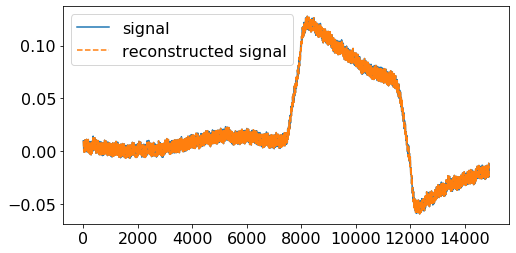

In [383]:
(cA1, cD1) = pywt.dwt(train_data[:, 0, :, 0][65], 'db2', 'smooth')
reconstructed_signal = pywt.idwt(cA1, cD1, 'db2', 'smooth')
 
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(train_data[:, 0, :, 0][65], label='signal')
ax.plot(reconstructed_signal, label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
plt.show()

In [837]:
train_lowpass_data = apply_lowpassfilter(train_data, train_batch_size)
print(lowpass_data.shape)

test_lowpass_data = apply_lowpassfilter(test_data, test_batch_size)
print(test_lowpass_data.shape)

(116, 14906)
(44, 14906)


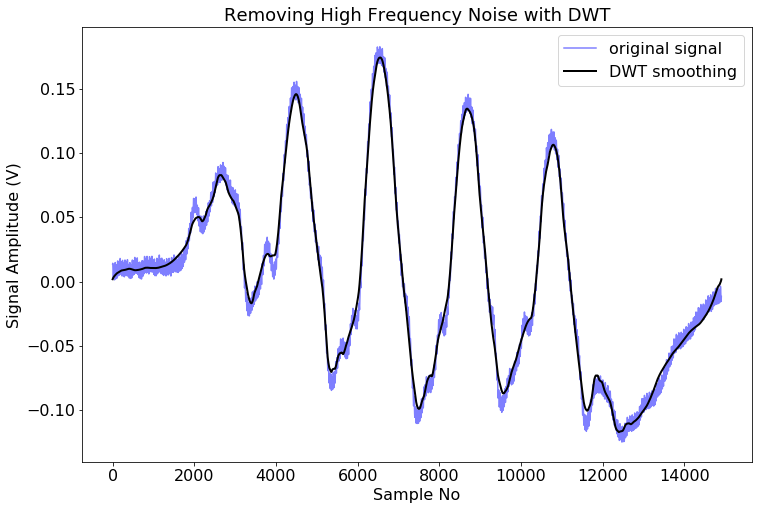

In [653]:
signal = train_data[10, 0, :, 0]
rec = train_lowpass_data[10, :]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
ax.plot(rec, 'k', label='DWT smoothing', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude (V)', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

13.214366912841797 seconds


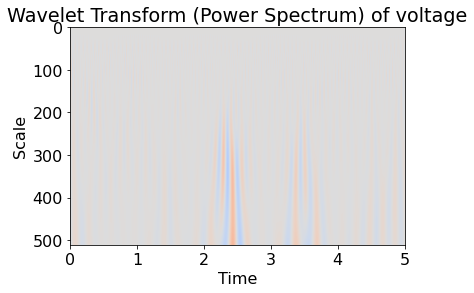

In [1365]:
import time
start_time = time.time()

def plot_cwt_coeffs_per_label(X, sample, scales, wavelet):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    coeffs, freqs = pywt.cwt(X.values.squeeze(), scales, wavelet = wavelet)
    
    # create scalogram
    ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto', extent=[0,5,scales.shape[0],0])
    ax.set_title("Wavelet Transform (Power Spectrum) of voltage")
    ax.set_ylabel('Scale')
    ax.set_xlabel('Time')

sample = 0
scales = np.arange(1, 512)
# mother wavelet
wavelet = 'morl'

plot_cwt_coeffs_per_label(fistForm, sample, scales, wavelet)

print("%s seconds" % (time.time() - start_time))